<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/E4P2S9_Faster_Sentiment_Analysis_using_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon Nov 23 15:30:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Source : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
from torchtext import data

#### Here we will use FastText model. FastText model uses concept of n-gram. In this example we are using bi-grams. A bi-gram is a pair of words/tokens that appear consecutively within a sentence. Eg: "My name is Anil !" --> bigram will be "My name", "name is", "is Anil", "Anil !". 
#### The 'generate_bigrams' function below takes a sentence that **has already been tokenized**, calculates the bi-grams and appends them to the end of the tokenized list.
#### Tokenized -> transformed from a string into a list of tokens eg:"Hello Anil" -> ["Hello", "Anil"]
#### Numericalized -> transformed from a list of tokens to a list of indexes


In [4]:
def generate_bigrams(x):
    
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    ### Let us understand above statement step-by-step. Input tokenized sentence will be like ['This', 'film', 'is', 'terrible']
    ### [x[i:] for i in range(2)] -> Creates a list -> [['This', 'film', 'is', 'terrible'], ['film', 'is', 'terrible']]
    ###                                                         x[0:]                            x[1:]
    ### zip(*[x[i:] for i in range(2)]) -> zip Creates an iterable object that pairs the sub-lists above. i.e 1st element 'This' in x[0:] paired with 1st element 'film' in x[1:] giving ('This', 'film') & so on.
    ### set(zip(*[x[i:] for i in range(2)])) -> wrapping inside 'set' gives meaning for zip iterable. We will get n_grams = {('This', 'film'), ('film', 'is'), ('is', 'terrible')}. 
    ### Please note that as we are using 'set' order may not be strictly as above. It could also be {('film', 'is'), ('is', 'terrible'), ('This', 'film')} 

    for n_gram in n_grams:
        x.append(' '.join(n_gram))
        ## This is for appending bigrams we got from above statement with our original tokenized input. 
        ## Input tokenized sentence x -> ['This', 'film', 'is', 'terrible'], n_grams generated -> {('This', 'film'), ('film', 'is'), ('is', 'terrible')}
        ## Modified tokenized x ->  ['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']
    
    return x    

In [5]:
generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'This film', 'is terrible', 'film is']

In [6]:
SEED = 1234

torch.manual_seed(SEED)                      # We are using seed to ensure that we get similar data while splitting train & test data
torch.backends.cudnn.deterministic = True
txt = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)   
# We are not using RNNs here, hence no need for pre-padded sequence and hence no need for 'include_lengths = True'
# 'preprocessing=generate_bigrams' will help us to pass our input through 'generate_bigrams' function. This will happen after tokenization is already applied
lbl = data.LabelField(dtype = torch.float)

#### train_data is organized in such a way that a single element contains a field, 'text', along with all the tokens representing the text, and a 'label' field that contains the label of the text (eg: in this case POS, NEG for sentiment analysis)

In [7]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(txt, lbl)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.70MB/s]


In [8]:
print('Length of train_data:',len(train_data), 'Type:', type(train_data))
print('Length of test_data :',len(test_data), 'Type:', type(test_data))
print(train_data.fields)
print(test_data.fields)
print(vars(train_data.examples[0]))   # vars -> Built-in function, with an argument equivalent to object.dict. 
# Please note the bigrams created after tokenization ends like 'After losing', 'losing the' etc.
print(vars(test_data.examples[0])) 
print(vars(train_data[-1]))

Length of train_data: 25000 Type: torchtext.datasets.imdb.IMDB
Length of test_data : 25000 Type: torchtext.datasets.imdb.IMDB
{'text': <torchtext.data.field.Field object at 0x7f4698dfd438>, 'label': <torchtext.data.field.LabelField object at 0x7f45f294d080>}
{'text': <torchtext.data.field.Field object at 0x7f4698dfd438>, 'label': <torchtext.data.field.LabelField object at 0x7f45f294d080>}
{'text': ['After', 'losing', 'the', 'Emmy', 'for', 'her', 'performance', 'as', 'Mama', 'Rose', 'in', 'the', 'television', 'version', 'of', 'GYPSY', ',', 'Bette', 'won', 'an', 'Emmy', 'the', 'following', 'year', 'for', 'BETTE', 'MIDLER', ':', 'DIVA', 'LAS', 'VEGAS', ',', 'a', 'live', 'concert', 'special', 'filmed', 'for', 'HBO', 'from', 'Las', 'Vegas', '.', 'Midler', ',', 'who', 'has', 'been', 'performing', 'live', 'on', 'stage', 'since', 'the', '1970', "'s", ',', 'proves', 'that', 'she', 'is', 'still', 'one', 'of', 'the', 'most', 'electrifying', 'live', 'performers', 'in', 'the', 'business', '.', 'Fro

##### Split the train_data further into train_data & valid_data

In [9]:
import random
train_data, valid_data = train_data.split(split_ratio=0.8,random_state=random.seed(SEED))

In [10]:
print('Length of train_data:',len(train_data))
print('Length of valid_data:',len(valid_data))
print('Length of test_data:',len(test_data))

Length of train_data: 20000
Length of valid_data: 5000
Length of test_data: 25000


### Building vocabulary. We take only top 25,000 words. One point to note that these 25,000 will include commonly occuring bigrams also. For example --> 'a welcome': 24740. Rest will be replaced with 'unk'. Also we are going to use pre-trained vector glove.6B.100d. This means glove was trained on 6 Billion words & have 100 dimensions. unk_init is meant for initialization of out-of-vocabulary word vectors (<unk>). Please note that building vocabulary means building a dictionary of words from input document.

In [11]:
max_vocab_size = 25_000
txt.build_vocab(train_data, max_size=max_vocab_size, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
lbl.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399572/400000 [00:23<00:00, 17233.29it/s]

In [12]:
print('Unique words in txt:',len(txt.vocab))   # 25,002 words because of unk & pad. Pad is used to make batch_size same for shorter sentences
print('Unique words in lbl:',len(lbl.vocab))

Unique words in txt: 25002
Unique words in lbl: 2


In [13]:
print(txt.vocab.freqs.most_common(25))  # Printing most commonly occuring 25 words

[('the', 231591), (',', 220110), ('.', 189374), ('a', 125362), ('and', 125134), ('of', 115176), ('to', 106945), ('is', 87093), ('in', 70127), ('I', 62105), ('it', 61215), ('that', 56406), ('"', 50319), ("'s", 49332), ('this', 48557), ('-', 42473), ('/><br', 40577), ('was', 40178), ('as', 34706), ('with', 34145), ('movie', 34138), ('for', 33681), ('film', 31061), ('The', 30221), ('but', 28021)]


## How to see vocabulary directly ? 
We can  see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.

In [14]:
print(txt.vocab.itos[:10])     # First 10
print(txt.vocab.itos[77:90])   # In between
print(txt.vocab.itos[-10:])    # Last 10. Please note that last 10 are bigrams because bigrams are appended after tokens

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']
['she', 'only', 'if', 'had', 'really', 'story', 'were', 'see', 'their', 'even', '. I', 'no', 'me']
['language and', 'late -', 'laugh -', 'leap', 'legends', 'let us', 'license', 'like so', 'lines to', 'listened']


In [15]:
print(txt.vocab.stoi)
print(lbl.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f4648aa3bf8>, {'<unk>': 0, '<pad>': 1, 'the': 2, ',': 3, '.': 4, 'a': 5, 'and': 6, 'of': 7, 'to': 8, 'is': 9, 'in': 10, 'I': 11, 'it': 12, 'that': 13, '"': 14, "'s": 15, 'this': 16, '-': 17, '/><br': 18, 'was': 19, 'as': 20, 'with': 21, 'movie': 22, 'for': 23, 'film': 24, 'The': 25, 'but': 26, '(': 27, ')': 28, "n't": 29, 'on': 30, 'you': 31, 'are': 32, 'not': 33, 'have': 34, 'his': 35, 'be': 36, 'he': 37, 'one': 38, '!': 39, 'at': 40, 'by': 41, 'all': 42, 'an': 43, 'who': 44, 'they': 45, 'from': 46, 'like': 47, 'so': 48, 'her': 49, "'": 50, 'or': 51, 'about': 52, 'has': 53, 'out': 54, 'It': 55, 'just': 56, 'of the': 57, 'do': 58, '?': 59, 'some': 60, 'good': 61, 'more': 62, '. The': 63, 'would': 64, 'very': 65, 'up': 66, 'what': 67, 'This': 68, ', and': 69, 'in the': 70, 'there': 71, 'time': 72, 'can': 73, 'which': 74, ', but': 75, 'when': 76, 'she': 77, 'only': 78, 'if': 79, 'had': 80, 'really': 81, 'story': 82, 'were': 83, 'see': 84, 't

#### Creating iterator. Using buckeiterator that will return batch of examples where each example is of similar length, minimizing the amount of padding per example. 

In [16]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                            batch_size = batch_size,
                                                                            device = device)

#### Model is as follows:
#### a) Emeddings are calculated for each word using embedding layer
#### b) Average of all word embeddings calculated
#### c) Average is sent to linear layer to get prediction sentiment
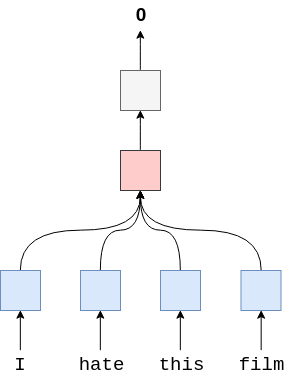

##### Averaging is done as follows. The image below is an example sentence after being converted into 5-dimensional word embeddings, with the words along the vertical axis and the embeddings along the horizontal axis. Each element in this [4x5] tensor is represented by a green block.The avg_pool2d uses a filter of size embedded.shape[1] (i.e. the length of the sentence) by 1. This is shown in pink in the image below. We calculate the average value of all elements covered by the filter, then the filter then slides to the right.
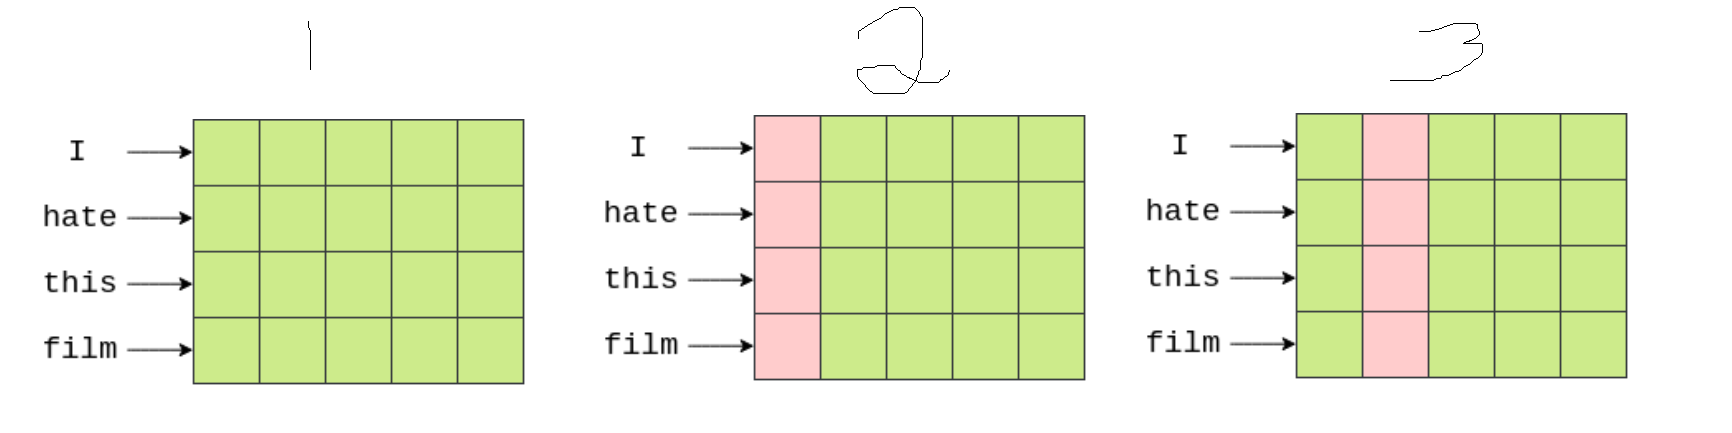

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
     def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
         super().__init__()
         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)  
         # We are passing idx of padded tokens so that we can avoid learning embeddings for <pad> token. 
         # <pad> tokens are irrelevant for our task here - ie predicting sentiment from movie reviews. 
         self.fc = nn.Linear(embedding_dim, output_dim)
     
     def forward(self, text):  
         #text = [sentence len, batch size] --> eg: [900, 64] means 64 sentences with 900 words each. Length of sentence will vary for each batch.
         embedded = self.embedding(text)
         #embedded = [sentence len, batch size, emb dim] --> [900, 64, 100] adding one more dimension for embed dimension

         embedded = embedded.permute(1,0,2)  
         #embedded = [batch size, sentence len, emb dim] --> [64, 900, 100]
         
         pooled   = F.avg_pool2d(embedded, (embedded.shape[1],1)).squeeze(1)
         # Average pooling -> accepts input 'embedded
         # Pooling filter used is ((embedded.shape[1],1)) --> (sentence len, 1) --> (900, 1). Pooling filter size changes based on sentence length
         # (900,100) after average pooling will get changed to (1,100). There will be 64 sentences ie. (64,1,100). squeeze(1) will make this (64,100)       
         # pooled = [batch size, embedding_dim] --> [64, 100]

         return self.fc(pooled)  

In [18]:
input_dim = len(txt.vocab)   # 25002
embedding_dim = 100          # EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier (glove.6B.100d) 
output_dim    = 1            # only 2 values - pos or neg as this is sentiment analysis
pad_idx       = txt.vocab.stoi[txt.pad_token]   #we are finding index of pad token i.e. we are finiding index of <pad> in vocabulary we built

model = FastText(input_dim, embedding_dim, output_dim, pad_idx)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


#### Copying the pre-trained word embeddings (txt.vocab that we built using 'build_vocab') we loaded earlier into the embedding layer of our model

In [20]:
pretrained_embeddings = txt.vocab.vectors
print(pretrained_embeddings.shape)
print(txt.vocab.vectors.shape)

torch.Size([25002, 100])
torch.Size([25002, 100])


#### Replace the initial weights of the embedding layer with the pre-trained embeddings.

In [21]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.6034, -1.3178,  0.2159,  ...,  0.1390,  0.6535, -0.2954],
        [-0.9925,  0.0165, -0.3103,  ..., -0.0149,  0.7623, -1.3961],
        [-0.0919,  0.4023,  0.0846,  ...,  0.1989, -0.0573,  0.6889]])

##### Manually setting rows corresponding to 'unk' and 'pad' in the embedding weights matrix to zeros.

In [22]:
unk_idx = txt.vocab.stoi[txt.unk_token]
print('unk_idx, txt.unk_token :', unk_idx, txt.unk_token)
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)
print(model.embedding.weight.data.shape)

unk_idx, txt.unk_token : 0 <unk>
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.6034, -1.3178,  0.2159,  ...,  0.1390,  0.6535, -0.2954],
        [-0.9925,  0.0165, -0.3103,  ..., -0.0149,  0.7623, -1.3961],
        [-0.0919,  0.4023,  0.0846,  ...,  0.1989, -0.0573,  0.6889]])
torch.Size([25002, 100])


##### SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. Hence using Adam in this example

In [23]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [24]:
criterion = nn.BCEWithLogitsLoss()

In [25]:
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [27]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for idx, batch in enumerate(iterator):       
        optimizer.zero_grad()      
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc  = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()    

    return epoch_loss / len(iterator), epoch_acc / len(iterator)   

In [28]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(iterator):      
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc  = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc  += acc.item() 

    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [29]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
n_epochs = 20
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Faster_Senti_Analysis_FastText.pt')
       
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.685 | Train Acc: 62.45%
	 Val. Loss: 0.616 |  Val. Acc: 71.95%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.630 | Train Acc: 76.26%
	 Val. Loss: 0.483 |  Val. Acc: 77.39%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.543 | Train Acc: 81.45%
	 Val. Loss: 0.417 |  Val. Acc: 82.14%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.462 | Train Acc: 85.53%
	 Val. Loss: 0.394 |  Val. Acc: 84.81%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.398 | Train Acc: 87.92%
	 Val. Loss: 0.399 |  Val. Acc: 86.37%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.351 | Train Acc: 89.41%
	 Val. Loss: 0.415 |  Val. Acc: 87.36%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.315 | Train Acc: 90.37%
	 Val. Loss: 0.436 |  Val. Acc: 87.68%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.286 | Train Acc: 91.13%
	 Val. Loss: 0.455 |  Val. Acc: 88.15%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.262 | Train Acc: 91.84%
	 Val. Loss: 0.473 |  Val. Acc: 88.65%
Epoch: 10 | Epoch Time: 0m 

In [31]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/EVA4P2_S9/E4P2_S9_Faster_Senti_Analysis_FastText.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.390 | Test Acc: 84.61%


##### Giving user input to get the sentiment back. Please note that we trained on movie review comments, hence input also should be similar text.

In [32]:
import spacy
nlp = spacy.load('en')  #'en' is language_id that indicates english

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]   # tokenizing the sentence
    print('tokenized:',tokenized)
    indexed = [txt.vocab.stoi[t] for t in tokenized]  # indexes the tokens by converting them into their integer representation from our vocabulary
    print('indexed:',indexed)
    tensor  = torch.LongTensor(indexed).to(device)  # converts 'indexed' which is a Python list into a PyTorch tensor
    tensor = tensor.unsqueeze(1)  # adding batch dimension to feed it to GPU
    prediction    = torch.sigmoid(model(tensor)) # Using sigmoid to keep the predictions between 0 & 1
    return prediction.item()

In [33]:
predict_sentiment(model, "pathetic movie")

tokenized: ['pathetic', 'movie']
indexed: [2537, 22]


6.627438017808238e-26

In [34]:
predict_sentiment(model, "a pathetic movie")  # Just adding 'a' dropped the score significantly

tokenized: ['a', 'pathetic', 'movie']
indexed: [5, 2537, 22]


4.379068685692862e-17

In [35]:
predict_sentiment(model, "simply superb")

tokenized: ['simply', 'superb']
indexed: [532, 1700]


1.0

In [36]:
predict_sentiment(model, "one time watch")

tokenized: ['one', 'time', 'watch']
indexed: [38, 72, 146]


0.9999947547912598

In [38]:
predict_sentiment(model, "not that bad")  # ------> # Still This is a problem. Negative words 'not', 'bad' etc. are bringing the score down

tokenized: ['not', 'that', 'bad']
indexed: [33, 13, 105]


4.3771091328574806e-27